In [1]:
pd.options.display.max_rows = 9999
pd.options.display.max_columns = 9999
import sys
import missingno as msno
import matplotlib.pyplot as plt
from matplotlib import rc
import seaborn as sns
from PIL import Image
from pandas_profiling import ProfileReport
from functools import reduce

%matplotlib inline
rc('font', family='AppleGothic')
plt.rcParams['axes.unicode_minus'] = False



from sklearn.model_selection import train_test_split
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.preprocessing import RobustScaler, StandardScaler, MinMaxScaler
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression,LinearRegression

from sklearn.metrics import confusion_matrix,classification_report,accuracy_score
from sklearn.model_selection import cross_val_score

배경지식 ESG

E-환경
S-사회
G-지배구조

ESG이란 원래 사회적인 책임을 지는 기업들의 환경과 사회, 지배구조 등 공공이익을 강조한 특수한 목적을 띄는 요소으로, 
기업이 공공의 이익에 기여함을 강조하는 유럽에서의 장기적인 성장에 중요한 요소로 생각하고 있으며, 
이를 활성화 시키기 장기투자펀드(ELTIF) 확대 및 사회적 기업 활성화 방안 모색을 통해 기업의 ESG 투자 활성화를 꾀함


유럽 공기업을 대상으로한 연구 결과

'Our findings suggest that ESG performance, especially concerning social and governance metrics, 
 meaningfully affects credit ratings.' (Devalle, Alain & Fiandrino, Simona & Cantino Valter, 2017, Conclusion.)
 
재무지표와 ESG 지표를 사용해 분석을 하였고 ESG가 신용평가에 유의미한 영향을 준다는 것으로 결론을 내림

Logistics regression 모델 사용 
   (환경)Env_Innov_Sc - 0.021 

   (사회)Community_Sc - 0.001

   (지배구조)Product_Resp_Sc - 0.037
   (지배구조)Shareholder_Sc - 0.001
 

한국에서의 ESG

신평사들은 ESG를 기업 신용등급에 영향을 주는 주요한 평가 요소로 별도 반영하는 것에는 조심스러운 반응이다

국내 신용평가사는 ESG 일부 요소가 이미 신용등급에 반영돼 있다는 입장이다. 
실제로 지배구조(G)가 취약한 기업의 경우 신용등급 산정 시 해당 요소가 부정적으로 작용한다.

'08~14년까지의 데이터를 보아 E는 음의 관계, S는 관계성이 낮고, G는 양의 관계를 가짐'
(Han et al. Asian Journal of Sustainability and Social Responsibility, 2016)


'연구 결과로는 ESG가 신용평가에 영향을 미치며 기업의 규모에 따라 조금 다르게 영향을 미칠 수 있음'
(ESG Scores and the Credit Market, 25 March 2020)

방향성으로는 ESG가 관계가 있다고 생각을 하고 현재까지의 데이터를 가지고 영향력의 유무를 분석하려고 하기위함

독립변수

재무지표

기업의 신용을 결정 할 때는 그 기업의 자산에 부채가 얼만큼 차지하는지 그 부채를 상환 할 수 있는 능력이 어떻게 되는지를 고려

    부채총계: 총 빌린돈
    자산총계: 기업의 자본과 부채의 총합 EX) 내 진짜 재산과 부채 또는 융자  

    매출액: 새전 벌어드린 금액
    당기순이익: 기업의 당기에 벌어들인 이익금 EX) 세후 연봉 
    
    운전자본: 회사가 운영되는데 필요한 돈 
        유동자산: 당기에 상환해야 될 빌린돈과 현금화가 빠른 자산의 총계
        재고자산: 아직 상품화하지 못한 자산 EX)아직 팔지 못한 물건들 또는 재료 
        
    유보액 :기업 활동을 하고 남은 처분 가능한 금액 EX) 다쓰고 남은돈 
        
선정기준: 분식회계 기업들의 더 좋은 신용평가를 받기위해 주로 조정하는 계정과목 

    Using Financial Statement Data to Identify Factors Associated with Fraudulent Financial reporting
    -OS Persons 저술 - ‎1995

ESG지표 
-E,S,G,ESG의 각 점수 ( KCGS : 한국기업지배구조원)

신용평가 등급(종속변수) 
- 11년부터 20년까지, D등급 부터 AAA까지

신용평가 점수 변화= 각 재무지표 + ESG지표

ESG 지표와 각 재무지표들을 x의 독립변수로 산정, 신용등급을 독립변수로 지정함 

처음에는 단순하게 각 독립변수에 변동 비율만을 적용을 하여 분석을 하였으나 아웃라이어가 크게 나오고,

편차가 매우큼, 양적인 영향력을 반영 할 수 없어 

재무지표의 비율을 자산총계 분으로 백분위화 하여 일괄 적용

## Credit Rating

In [2]:
df_credit_2020 = pd.read_excel("2020_credit_rating.xlsx")
df_credit_2020.head()

,Unnamed: 0,평가회사,평가대상회사,평가대상종류,공시일자,평가등급,등급감시,등급전망
0,1,한국기업평가,삼성엔지니어링(주),본평가,2020-01-02,A-,NaN,안정적
1,2,한국기업평가,삼화페인트공업(주),수시평가,2020-01-02,BBB+,NaN,안정적
2,3,나이스신용평가,예금보험공사,본평가,2020-01-08,AAA,NaN,안정적
3,4,한국기업평가,에스케이증권(주),본평가,2020-01-09,A,NaN,안정적
4,5,한국기업평가,우리종합금융(주),본평가 (정정),2020-01-09,A,NaN,안정적


In [3]:
# msno.matrix(df_credit_2020)
# plt.show()

In [4]:
def screen_name(df):
    df = df.rename(columns = {"평가대상회사":"기업명"})
    df = df[["기업명","공시일자","평가등급"]]
    df["공시일자"] = df["공시일자"].apply(lambda x: int(str(x)[:4]))
    df["평가등급"][df["평가등급"] == "취소"] = np.nan
    df["기업명"] = df["기업명"].apply(lambda x: str(x).replace("(주)",""))
    df = df.dropna()
    df = df.drop_duplicates(['기업명'],keep="last").reset_index(drop=True)
    df['평가등급'] = df['평가등급'].apply(credit_dlist.get)
    return df


#  def give_point(df1, df2): 
#     df_n = pd.merge(df1, df2, on = "기업명", how = "inner").dropna()
#     df_n["Point"] = df_n["평가등급_x"] - df_n["평가등급_y"]
#     df_n["Point"][df_n["Point"].values > 0] =1
#     df_n["Point"][df_n["Point"].values < 0] =-1
#     return df_n[["기업명","Point"]]


def change_columns(df):
    columns = ["종목코드","기업명","결산월","단위","2019","2018","2017","2016","2015","2014"
               ,"2013","2012","2011","2010","2009","2008"]
    df.columns = columns
    df = df.rename(columns = {"종목코드":"기업코드"})
    return df


def merge_code(dfa,dfb):
    dfb = dfb[["기업코드","기업명"]][dfb["기업명"].isin(dfa["기업명"])]
    dfa = pd.merge(dfa,dfb, on="기업명",how="inner")
    return dfa


def calculate_df(df1, df2, df3):    
    df3.iloc[:,0] = df1.iloc[:,0]    
    for i in range(1,21):
        if i <=17:            
            df3.iloc[:,i] = ((df1.iloc[:,i] - df2.iloc[:,i]))/(np.abs(df2.iloc[:,i]))
        else:
            df3.iloc[:,i] = (df1.iloc[:,i] - df2.iloc[:,i])/2
            
    return df3.rename(columns={'자산총계':"TA",'이자보상배율':'INTCOV','ROA':'ROA','ROE':'ROE',
                            '총자산_총자본':'EQTA','유동비율':'CURR','비유동부채_자산':'LTDTA',
                              '사회':'S','환경':'E','지배구조':'G', "당기순이익":'NI','자산총계':'TASSET',
                              '매출액':'Sale','부채비율':'DR','차입부채_EBITDA':'BTEBITDA','EBITDA_이자비용':'EBITDATIE',
                              '총차입부채':'TB','EBIT_매출액':'EBITTS'})

In [5]:
# credit_dlist={"D":0,"C-":1,"C":2,"C+":3,"CC-":4,"CC":5,"CC+":6,"CCC-":7,"CCC":8,"CCC+":9,
#               "B-":10,"B":11,"B+":12,"BB-":13,"BB":14,"BB+":15,"BBB-":16,"BBB":17,"BBB+":18,
#               "A-":19,"A":20,"A+":21,"AA-":22,"AA":23,"AA+":24,"AAA-":25,"AAA":26,"AAA+":27}

credit_dlist={"D":20,"C-":20,"C":20,"C+":20,"CC-":20,"CC":20,"CC+":20,"CCC-":30,"CCC":30,"CCC+":30,
              "B-":30,"B":30,"B+":30,"BB-":30,"BB":40,"BB+":40,"BBB-":40,"BBB":40,"BBB+":40,
              "A-":40,"A":40,"A+":50,"AA-":50,"AA":50,"AA+":50,"AAA-":50,"AAA":50,"AAA+":50}

df_credit_2017 = screen_name(pd.read_excel("2017_credit_rating.xlsx"))
df_credit_2018 = screen_name(pd.read_excel("2018_credit_rating.xlsx"))
df_credit_2019 = screen_name(pd.read_excel("2019_credit_rating.xlsx"))
df_credit_2020 = screen_name(pd.read_excel("2020_credit_rating.xlsx"))
df_2013_2016_credit = pd.read_excel("2013-2016_credit_rating.xlsx")
df_2013_2016_credit.columns = ["nnamed", "평가회사","기업명","평가","평가대상종류","공시일자","평가등급","등급감시","등급전망"]
df_2013_2016_credit["공시일자"] = df_2013_2016_credit["공시일자"].apply(lambda x: int(str(x)[:4]))

df_credit_2013 = screen_name(df_2013_2016_credit[df_2013_2016_credit["공시일자"] == 2013])
df_credit_2014 = screen_name(df_2013_2016_credit[df_2013_2016_credit["공시일자"] == 2014])
df_credit_2015 = screen_name(df_2013_2016_credit[df_2013_2016_credit["공시일자"] == 2015])
df_credit_2016 = screen_name(df_2013_2016_credit[df_2013_2016_credit["공시일자"] == 2016])


In [6]:
# sns.catplot(x="기업명", y="평가등급",data=df_credit_2017)
# plt.title("기업별 신용등급 분포")
# plt.ylabel("신용등급")
# plt.xlabel("기업")
# plt.ylim(0,30)

# plt.tick_params(axis='x',which='both', bottom=False, top=False, labelbottom=False)

# plt.figure(figsize=(50,50))

# plt.show()

In [7]:
list_credit = [df_credit_2013,df_credit_2014,df_credit_2015,df_credit_2016,df_credit_2017,
             df_credit_2018,df_credit_2019,df_credit_2020]


mod = sys.modules[__name__]

# for i in range(2014,2021):
#     setattr(mod, 'df_credit_{}'.format(i), give_point(list_credit[i-2014],list_credit[i-2013]))
    
df_credit_2020.head()

,기업명,공시일자,평가등급
0,삼성엔지니어링,2020,40
1,에스케이증권,2020,40
2,농협경제지주,2020,50
3,이지바이오,2020,40
4,동부건설,2020,40


## ESG

In [8]:
df_esg = pd.read_csv("2011-2019-ESG.tsv", sep='\t')
df_esg.head()

,NO,기업명,기업코드,ESG등급,지배구조,사회,환경,평가년도,비고
0,6567,AJ네트웍스,95570,B,B,B,C이하,2019,NaN
1,6566,AJ렌터카,68400,C이하,C,B,B,2019,NaN
2,6565,AK홀딩스,6840,B,B,B,C이하,2019,NaN
3,6564,AP시스템,265520,C이하,B,C이하,C이하,2019,NaN
4,6563,BGF,27410,B,B,A,C이하,2019,NaN


In [9]:
# msno.matrix(df_esg)
# plt.show()

In [10]:
df_esg = df_esg.drop(columns = ['NO', '비고']).dropna()
df_esg.기업코드 = df_esg.기업코드.apply(lambda x: str(x).zfill(6))

di = {"S":70.0,"A+":60.0,"A":50.0,"B+":40.0,"B":30.0,"B이하":30.0,"C":20.0,"C이하":20.0,"D":10.0}

df_esg.ESG등급 = list(map(di.get, df_esg.ESG등급))
df_esg.환경 = list(map(di.get, df_esg.환경))
df_esg.사회= list(map(di.get, df_esg.사회))
df_esg.지배구조= list(map(di.get, df_esg.지배구조))

mod = sys.modules[__name__]

for i in range(2011,2020):
    setattr(mod, 'df_esg_{}'.format(i),df_esg[df_esg["평가년도"]==i])
    
df_esg_2011.head()

,기업명,기업코드,ESG등급,지배구조,사회,환경,평가년도
5904,AK홀딩스,006840,30.0,30.0,30.0,30.0,2011
5905,BYC,001460,30.0,30.0,30.0,30.0,2011
5908,CJ대한통운,000120,40.0,30.0,40.0,30.0,2011
5910,CJ제일제당,097950,40.0,40.0,40.0,50.0,2011
5914,DB손해보험,005830,50.0,50.0,50.0,40.0,2011


In [11]:
# sns.catplot(x="평가년도", y="ESG등급",hue="ESG등급",data=df_esg.iloc[:,2:])
# plt.title("연도별 ESG등급 그래프")
# plt.ylabel("ESG 등급")
# plt.ylim(0,70)
# plt.figure(figsize=(100,100))
# plt.show()

## Balance Sheet

In [12]:
df_f = ["비유동부채.xlsx","자산총계.xlsx","이자보상배율.xlsx","ROA(당기순이익).xlsx","ROE(당기순이익).xlsx","총자산_총자본.xlsx",
        "유동비율.xlsx","영업활동현금흐름.xlsx","EBITDA.xlsx","CAPEX.xlsx","당기순이익.xlsx","자산총계.xlsx","매출액.xlsx","EBIT.xlsx",
       "부채비율.xlsx","차입부채_EBITDA.xlsx","EBITDA_이자비용.xlsx","총차입부채.xlsx"]

for i in range(1,19):
    setattr(mod, 'df_balance_{}'.format(i), change_columns(pd.read_excel(df_f[i-1])[9:]))

balance_list = [df_balance_3, df_balance_4, df_balance_5, df_balance_6,df_balance_7,df_balance_8,df_balance_9,df_balance_10,df_balance_11,
               df_balance_12,df_balance_13,df_balance_14,df_balance_15,df_balance_16,df_balance_17]

for i in range(15): 
    balance_list[i][ (balance_list[i].values == "N/A(IFRS)") | (balance_list[i].values== '완전잠식')] = np.nan
    for k in range(4,15): 
        balance_list[i].iloc[:,k] = balance_list[i].iloc[:,k].apply(lambda x: float(str(x)))
        

In [13]:
# msno.matrix(df_balance_1)
# plt.show()

In [14]:
list_credit = [df_credit_2013,df_credit_2014,df_credit_2015,df_credit_2016,df_credit_2017,
             df_credit_2018,df_credit_2019]

list_esg = [df_esg_2011,df_esg_2012,df_esg_2013,df_esg_2014,df_esg_2015,df_esg_2016,
            df_esg_2017,df_esg_2018,df_esg_2019]

list_balance = [df_balance_1,df_balance_2,df_balance_3,df_balance_4,df_balance_5,
               df_balance_6,df_balance_7,df_balance_8,df_balance_9,df_balance_10,
               df_balance_11,df_balance_12,df_balance_13,df_balance_14,df_balance_15,
               df_balance_16,df_balance_17,df_balance_18]


df_columns = ["기업코드","비유동부채","자산총계","이자보상배율","ROA","ROE","총자산_총자본","유동비율","영업활동현금흐름",
             "EBITDA","CAPEX","당기순이익","자산총계","매출액","EBIT","부채비율","차입부채_EBITDA","EBITDA_이자비용","총차입부채"]


for i in range(2013,2020):
    setattr(mod, 'df_rating_{}'.format(i), merge_code(list_credit[i-2013],list_esg[i-2013]))

for k in range(2011, 2020):
    for i in range(1,19):
        setattr(mod, 'df_{}_{}'.format(k,i), (pd.DataFrame(list_balance[i-1].iloc[:,[0,2023-k]]))) 

In [15]:
data_frames_2011 = [df_2011_1,df_2011_2,df_2011_3,df_2011_4,df_2011_5,df_2011_6,df_2011_7,df_2011_8,df_2011_9,df_2011_10,
                   df_2011_11,df_2011_12,df_2011_13,df_2011_14,df_2011_15,df_2011_16,df_2011_17,df_2011_18]
df_merged_2011 = reduce(lambda left,right: pd.merge(left,right,on=['기업코드'], how='inner'), data_frames_2011).dropna()
df_merged_2011.columns = df_columns

data_frames_2012 = [df_2012_1,df_2012_2,df_2012_3,df_2012_4,df_2012_5,df_2012_6,df_2012_7,df_2012_8,df_2012_9,df_2012_10,
                   df_2012_11,df_2012_12,df_2012_13,df_2012_14,df_2012_15,df_2012_16,df_2012_17,df_2012_18]
df_merged_2012 = reduce(lambda left,right: pd.merge(left,right,on=['기업코드'], how='inner'), data_frames_2012).dropna()
df_merged_2012.columns = df_columns

data_frames_2013 = [df_2013_1,df_2013_2,df_2013_3,df_2013_4,df_2013_5,df_2013_6,df_2013_7,df_2013_8,df_2013_9,df_2013_10,
                   df_2013_11,df_2013_12,df_2013_13,df_2013_14,df_2013_15,df_2013_16,df_2013_17,df_2013_18]
df_merged_2013 = reduce(lambda left,right: pd.merge(left,right,on=['기업코드'], how='inner'), data_frames_2013).dropna()
df_merged_2013.columns = df_columns

data_frames_2014 = [df_2014_1,df_2014_2,df_2014_3,df_2014_4,df_2014_5,df_2014_6,df_2014_7,df_2014_8,df_2014_9,df_2014_10,
                   df_2014_11,df_2014_12,df_2014_13,df_2014_14,df_2014_15,df_2014_16,df_2014_17,df_2014_18]
df_merged_2014 = reduce(lambda left,right: pd.merge(left,right,on=['기업코드'], how='inner'), data_frames_2014).dropna()
df_merged_2014.columns = df_columns

data_frames_2015 = [df_2015_1,df_2015_2,df_2015_3,df_2015_4,df_2015_5,df_2015_6,df_2015_7,df_2015_8,df_2015_9,df_2015_10,
                   df_2015_11,df_2015_12,df_2015_13,df_2015_14,df_2015_15,df_2015_16,df_2015_17,df_2015_18]
df_merged_2015 = reduce(lambda left,right: pd.merge(left,right,on=['기업코드'], how='inner'), data_frames_2015).dropna()
df_merged_2015.columns = df_columns

data_frames_2016 = [df_2016_1,df_2016_2,df_2016_3,df_2016_4,df_2016_5,df_2016_6,df_2016_7,df_2016_8,df_2016_9,df_2016_10,
                   df_2016_11,df_2016_12,df_2016_13,df_2016_14,df_2016_15,df_2016_16,df_2016_17,df_2016_18]
df_merged_2016 = reduce(lambda left,right: pd.merge(left,right,on=['기업코드'], how='inner'), data_frames_2016).dropna()
df_merged_2016.columns = df_columns

data_frames_2017 = [df_2017_1,df_2017_2,df_2017_3,df_2017_4,df_2017_5,df_2017_6,df_2017_7,df_2017_8,df_2017_9,df_2017_10,
                   df_2017_11,df_2017_12,df_2017_13,df_2017_14,df_2017_15,df_2017_16,df_2017_17,df_2017_18]
df_merged_2017 = reduce(lambda left,right: pd.merge(left,right,on=['기업코드'], how='inner'), data_frames_2017).dropna()
df_merged_2017.columns = df_columns

data_frames_2018 = [df_2018_1,df_2018_2,df_2018_3,df_2018_4,df_2018_5,df_2018_6,df_2018_7,df_2018_8,df_2018_9,df_2018_10,
                   df_2018_11,df_2018_12,df_2018_13,df_2018_14,df_2018_15,df_2018_16,df_2018_17,df_2018_18]
df_merged_2018 = reduce(lambda left,right: pd.merge(left,right,on=['기업코드'], how='inner'), data_frames_2018).dropna()
df_merged_2018.columns = df_columns

data_frames_2019 = [df_2019_1,df_2019_2,df_2019_3,df_2019_4,df_2019_5,df_2019_6,df_2019_7,df_2019_8,df_2019_9,df_2019_10,
                   df_2019_11,df_2019_12,df_2019_13,df_2019_14,df_2019_15,df_2019_16,df_2019_17,df_2019_18]
df_merged_2019 = reduce(lambda left,right: pd.merge(left,right,on=['기업코드'], how='inner'), data_frames_2019).dropna()
df_merged_2019.columns = df_columns

In [16]:
df_merged_2019.columns

Index(['기업코드', '비유동부채', '자산총계', '이자보상배율', 'ROA', 'ROE',
       '총자산_총자본', '유동비율', '영업활동현금흐름', 'EBITDA', 'CAPEX',
       '당기순이익', '자산총계', '매출액', 'EBIT', '부채비율', '차입부채_EBITDA', 'EBITDA_이자비용',
       '총차입부채'],
      dtype='object')

In [17]:
list_merge = [df_merged_2011,df_merged_2012,df_merged_2013,df_merged_2014,df_merged_2015,df_merged_2016,df_merged_2017,
             df_merged_2018,df_merged_2019]

for i in range(2011,2020):
    list_merge[i-2011]["비유동부채_자산"] = list_merge[i-2011]['비유동부채']/list_merge[i-2011]['자산총계']
    list_merge[i-2011]['총자산_총자본'] = list_merge[i-2011]['총자산_총자본'].apply(lambda x: np.reciprocal(x))
    list_merge[i-2011]["FCF"] = list_merge[i-2011]['영업활동현금흐름'] - list_merge[i-2011]["CAPEX"]
    list_merge[i-2011]["EBIT_매출액"] = list_merge[i-2011]["EBIT"]/list_merge[i-2011]["매출액"]
    list_merge[i-2011]["자산총계"] = list_merge[i-2011]['자산총계'].apply(lambda x: np.log(x))
    list_merge[i-2011]["비유동부채_자산"] = list_merge[i-2011]["비유동부채_자산"].apply(lambda x: np.log(x))
    list_merge[i-2011]["유동비율"] = list_merge[i-2011]["유동비율"].apply(lambda x: np.log(x))
    list_merge[i-2011]["이자보상배율"] = list_merge[i-2011]["이자보상배율"].apply(lambda x: np.log(x))
    
    setattr(mod, 'df_merged_b_{}'.format(i), pd.merge(list_merge[i-2011], \
                                                list_esg[i-2011],on=['기업코드'], how='inner').iloc[:,[0,3,4,5,6,7,9,11,12,13,
                                                                                               15,16,17,18,19,20,21,23,24,25,26]])

In [18]:
df_merged_b_2012.head()

,기업코드,이자보상배율,ROA,ROE,총자산_총자본,유동비율,EBITDA,당기순이익,자산총계,매출액,부채비율,차입부채_EBITDA,EBITDA_이자비용,총차입부채,비유동부채_자산,FCF,EBIT_매출액,ESG등급,지배구조,사회,환경
0,000020,2.248129,0.40,0.57,0.007000,4.988867,22203932.0,1311241.0,3.242847e+08,2.233720e+08,42.86,0.45,21.03,1.000000e+07,-3.094445,18465809.0,0.044781,30.0,40.0,30.0,30.0
1,000050,-1.021651,-0.59,-1.27,0.005145,4.317221,30340204.0,-7910168.0,1.335040e+09,3.336208e+08,115.08,13.69,1.64,4.153193e+08,-0.887915,-20187568.0,0.021743,30.0,30.0,30.0,30.0
2,000070,0.336472,5.60,8.76,0.008220,5.094915,62369435.0,129744740.0,2.748399e+09,1.864066e+09,65.27,10.36,2.58,6.462661e+08,-2.003824,-350113228.0,0.010664,30.0,30.0,30.0,40.0
3,000080,0.854415,2.92,7.31,0.004060,4.009513,288819050.0,103536195.0,3.518666e+09,2.034626e+09,149.72,4.71,3.57,1.360940e+09,-1.709587,-198648623.0,0.082155,40.0,40.0,30.0,40.0
4,000120,1.420696,1.92,3.03,0.007713,4.726148,229897603.0,69571921.0,3.669501e+09,2.627466e+09,57.62,3.74,11.80,8.589212e+08,-1.599817,-139540581.0,0.054436,30.0,30.0,40.0,30.0


## DataFrame Merge

In [19]:
df_merged_z_2012 = df_merged_b_2012[df_merged_b_2012["기업코드"].isin(list(set(df_merged_b_2011["기업코드"])&set(df_merged_b_2012["기업코드"])))].reset_index(drop=True)
df_merged_z_2011 = df_merged_b_2011[df_merged_b_2011["기업코드"].isin(list(set(df_merged_b_2011["기업코드"])&set(df_merged_b_2012["기업코드"])))].reset_index(drop=True)

df_merged_c_2012 = pd.DataFrame(columns=df_merged_b_2012.columns)
df_total_2013 = pd.merge(df_rating_2013, calculate_df(df_merged_z_2012,df_merged_z_2011,df_merged_c_2012),on="기업코드", how="inner")

In [20]:
df_merged_z_2013 = df_merged_b_2013[df_merged_b_2013["기업코드"].isin(list(set(df_merged_b_2013["기업코드"])&set(df_merged_b_2012["기업코드"])))].reset_index(drop=True)
df_merged_z_2012 = df_merged_b_2012[df_merged_b_2012["기업코드"].isin(list(set(df_merged_b_2013["기업코드"])&set(df_merged_b_2012["기업코드"])))].reset_index(drop=True)

df_merged_c_2013 = pd.DataFrame(columns=df_merged_b_2013.columns)
df_total_2014 = pd.merge(df_rating_2014, calculate_df(df_merged_z_2013,df_merged_z_2012,df_merged_c_2013),on="기업코드", how="inner")

In [21]:
df_merged_z_2014 = df_merged_b_2014[df_merged_b_2014["기업코드"].isin(list(set(df_merged_b_2014["기업코드"])&set(df_merged_b_2013["기업코드"])))].reset_index(drop=True)
df_merged_z_2013 = df_merged_b_2013[df_merged_b_2013["기업코드"].isin(list(set(df_merged_b_2014["기업코드"])&set(df_merged_b_2013["기업코드"])))].reset_index(drop=True)

df_merged_c_2014 = pd.DataFrame(columns=df_merged_b_2014.columns)
df_total_2015 = pd.merge(df_rating_2015, calculate_df(df_merged_z_2014,df_merged_z_2013,df_merged_c_2014),on="기업코드", how="inner")

In [22]:
df_merged_z_2015 = df_merged_b_2015[df_merged_b_2015["기업코드"].isin(list(set(df_merged_b_2014["기업코드"])&set(df_merged_b_2015["기업코드"])))].reset_index(drop=True)
df_merged_z_2014 = df_merged_b_2014[df_merged_b_2014["기업코드"].isin(list(set(df_merged_b_2014["기업코드"])&set(df_merged_b_2015["기업코드"])))].reset_index(drop=True)

df_merged_c_2015 = pd.DataFrame(columns=df_merged_b_2014.columns)
df_total_2016 = pd.merge(df_rating_2016, calculate_df(df_merged_z_2015,df_merged_z_2014,df_merged_c_2015),on="기업코드", how="inner")


In [23]:
# plt.figure(figsize=(10,5))
# sns.boxplot(data=df_total_2015.iloc[:,3:], palette = "RdBu")
# plt.show()

In [24]:
# plt.figure(figsize=(10,5))
# sns.boxplot(data=df_total_2016.iloc[:,3:], palette = "RdBu")
# plt.show()

In [25]:
df_merged_z_2016 = df_merged_b_2016[df_merged_b_2016["기업코드"].isin\
(list(set(df_merged_b_2014["기업코드"])&set(df_merged_b_2016["기업코드"])&set(df_merged_b_2015["기업코드"])))].reset_index(drop=True)

df_merged_z_2015 = df_merged_b_2015[df_merged_b_2015["기업코드"].isin\
(list(set(df_merged_b_2014["기업코드"])&set(df_merged_b_2016["기업코드"])&set(df_merged_b_2015["기업코드"])))].reset_index(drop=True)

df_merged_c_2016 = pd.DataFrame(columns=df_merged_b_2014.columns)
df_total_2017 = pd.merge(df_rating_2017, calculate_df(df_merged_z_2016,df_merged_z_2015,df_merged_c_2016),on="기업코드", how="inner")

In [26]:
df_total_2017.head()

,기업명,공시일자,평가등급,기업코드,INTCOV,ROA,ROE,EQTA,CURR,EBITDA,NI,TASSET,Sale,DR,BTEBITDA,EBITDATIE,TB,LTDTA,FCF,EBITTS,ESG등급,G,S,E
0,한일시멘트,2017,50.0,003300,0.185371,0.279605,0.253363,0.044618,0.049997,-0.098924,0.291025,0.003615,0.046369,-0.111350,-0.069930,0.551240,-0.166655,0.017955,-0.813538,-0.195147,-0.250000,-5.0,-5.0,0.0
1,롯데푸드,2017,50.0,002270,0.199839,0.093827,0.087479,0.017637,-0.050727,0.102376,0.157112,0.037720,0.032912,-0.056497,-0.287879,0.730851,-0.214107,-0.213844,-1.205512,0.116413,0.333333,5.0,10.0,5.0
2,JW중외제약,2017,40.0,001060,0.718076,-6.242424,-5.954545,0.156806,0.025602,0.096370,-6.574280,0.061284,0.076235,-0.212232,-0.211382,0.273381,-0.135414,-0.092582,0.717994,0.059235,0.000000,5.0,0.0,0.0
3,송원산업,2017,40.0,004430,0.660780,0.495549,0.330517,0.162178,0.074769,0.327168,0.474743,-0.019918,0.060978,-0.198758,-0.375000,0.617560,-0.168901,0.290706,0.239048,0.457014,0.000000,0.0,0.0,0.0
4,하이트진로,2017,40.0,000080,0.034967,-0.277419,-0.268657,-0.004141,0.033152,-0.044125,-0.279476,-0.017164,-0.009042,0.012465,0.015837,0.102752,-0.028576,0.010203,-0.101902,-0.066050,0.000000,-5.0,0.0,0.0


In [27]:
# plt.figure(figsize=(10,5))
# sns.boxplot(data=df_total_2017.iloc[:,3:], palette = "RdBu")
# plt.show()

In [28]:
df_merged_z_2017 = df_merged_b_2017[df_merged_b_2017["기업코드"].isin\
(list(set(df_merged_b_2017["기업코드"])&set(df_merged_b_2016["기업코드"])&set(df_merged_b_2015["기업코드"])))].reset_index(drop=True)

df_merged_z_2016 = df_merged_b_2016[df_merged_b_2016["기업코드"].isin\
(list(set(df_merged_b_2017["기업코드"])&set(df_merged_b_2016["기업코드"])&set(df_merged_b_2015["기업코드"])))].reset_index(drop=True)

df_merged_z_2015 = df_merged_b_2015[df_merged_b_2015["기업코드"].isin\
(list(set(df_merged_b_2017["기업코드"])&set(df_merged_b_2016["기업코드"])&set(df_merged_b_2015["기업코드"])))].reset_index(drop=True)

df_merged_c_2017 = pd.DataFrame(columns=df_merged_b_2014.columns)
df_total_2018 = pd.merge(df_rating_2018, calculate_df(df_merged_z_2017,df_merged_z_2016,df_merged_c_2017),on="기업코드", how="inner")

In [29]:
# plt.figure(figsize=(10,5))
# sns.boxplot(data=df_total_2018.iloc[:,3:], palette = "RdBu")
# plt.show()

In [30]:
df_merged_z_2018 = df_merged_b_2018[df_merged_b_2018["기업코드"].isin\
(list(set(df_merged_b_2017["기업코드"])&set(df_merged_b_2016["기업코드"])&set(df_merged_b_2018["기업코드"])))].reset_index(drop=True)

df_merged_z_2017 = df_merged_b_2017[df_merged_b_2017["기업코드"].isin\
(list(set(df_merged_b_2017["기업코드"])&set(df_merged_b_2016["기업코드"])&set(df_merged_b_2018["기업코드"])))].reset_index(drop=True)

df_merged_z_2016 = df_merged_b_2016[df_merged_b_2016["기업코드"].isin\
(list(set(df_merged_b_2017["기업코드"])&set(df_merged_b_2016["기업코드"])&set(df_merged_b_2018["기업코드"])))].reset_index(drop=True)

df_merged_c_2018 = pd.DataFrame(columns=df_merged_b_2014.columns)
df_total_2019 = pd.merge(df_rating_2019, calculate_df(df_merged_z_2018,df_merged_z_2017,df_merged_c_2016),on="기업코드", how="inner")

In [31]:
# plt.figure(figsize=(10,8))
# sns.boxplot(data=df_total_2019.iloc[:,3:], palette = "RdBu")
# plt.show()

In [32]:
df_merged_z_2019 = df_merged_b_2019[df_merged_b_2019["기업코드"].isin\
(list(set(df_merged_b_2017["기업코드"])&set(df_merged_b_2019["기업코드"])&set(df_merged_b_2018["기업코드"])))].reset_index(drop=True)

df_merged_z_2018 = df_merged_b_2018[df_merged_b_2018["기업코드"].isin\
(list(set(df_merged_b_2017["기업코드"])&set(df_merged_b_2019["기업코드"])&set(df_merged_b_2018["기업코드"])))].reset_index(drop=True)

df_merged_z_2017 = df_merged_b_2017[df_merged_b_2017["기업코드"].isin\
(list(set(df_merged_b_2017["기업코드"])&set(df_merged_b_2019["기업코드"])&set(df_merged_b_2018["기업코드"])))].reset_index(drop=True)

df_merged_c_2019 = pd.DataFrame(columns=df_merged_b_2014.columns)
df_merged_c_2019 = calculate_df(df_merged_z_2019,df_merged_z_2018,df_merged_c_2019)
df_rating_2020 = merge_code(df_credit_2020, df_esg_2019)
df_total_2020 = pd.merge(df_rating_2020,df_merged_c_2019.dropna(), on="기업코드", how="inner")

In [33]:
# plt.figure(figsize=(10,5))
# sns.boxplot(data=df_total_2020.iloc[:,3:], palette = "RdBu")
# plt.show()

In [34]:
df_sum_2015_2020 = pd.concat([df_total_2015,df_total_2016,df_total_2017,\
                              df_total_2018,df_total_2019,df_total_2020]).replace(np.inf,np.nan).dropna().reset_index(drop=True)


df_sum_2015_2020.describe()

,공시일자,평가등급,INTCOV,ROA,ROE,EQTA,CURR,EBITDA,NI,TASSET,Sale,DR,BTEBITDA,EBITDATIE,TB,LTDTA,FCF,EBITTS,ESG등급,G,S,E
count,404.000000,404.000000,404.000000,404.000000,404.000000,404.000000,404.000000,404.000000,404.000000,404.000000,404.000000,404.000000,404.000000,404.000000,404.000000,404.000000,404.000000,404.000000,404.000000,404.000000,404.000000,404.000000
mean,2017.126238,45.371287,0.617694,0.411814,0.355909,0.053762,0.002363,0.070246,0.545005,0.047982,0.035101,-0.004458,0.079398,0.271800,0.071073,-0.033000,-0.203251,0.194005,0.012211,0.210396,0.272277,-0.086634
std,1.558266,5.139326,7.687728,8.534170,8.450199,0.489215,0.046139,0.337112,8.949687,0.118779,0.110486,0.225081,0.561715,1.267729,0.458331,0.250819,39.982591,1.633675,0.156689,4.567421,3.734372,2.622657
min,2015.000000,30.000000,-7.701554,-65.375000,-70.150000,-0.500261,-0.137617,-0.749420,-64.831159,-0.669216,-0.330018,-0.862001,-1.000000,-0.881663,-1.000000,-2.286802,-603.721385,-0.944091,-0.400000,-15.000000,-15.000000,-10.000000
25%,2016.000000,40.000000,-0.145548,-0.469488,-0.458087,-0.024806,-0.021301,-0.100051,-0.440938,-0.009612,-0.014569,-0.109760,-0.190271,-0.140795,-0.088152,-0.108699,-1.000742,-0.220306,0.000000,-5.000000,0.000000,0.000000
50%,2017.000000,50.000000,0.013993,-0.079729,-0.088147,0.014707,0.001289,0.026357,0.002026,0.030219,0.030450,-0.020912,-0.013027,0.043568,0.002161,-0.021594,0.065008,-0.038093,0.000000,0.000000,0.000000,0.000000
75%,2018.000000,50.000000,0.213574,0.499800,0.496764,0.059981,0.023862,0.160246,0.602803,0.081478,0.077160,0.062634,0.211705,0.315981,0.130273,0.083728,1.467545,0.196773,0.000000,5.000000,0.000000,0.000000
max,2020.000000,50.000000,133.569303,128.000000,114.040000,9.270804,0.174697,3.376874,130.438887,0.667023,0.730684,1.508483,5.317073,17.681468,4.048157,0.658431,494.521805,26.150152,0.666667,15.000000,15.000000,10.000000


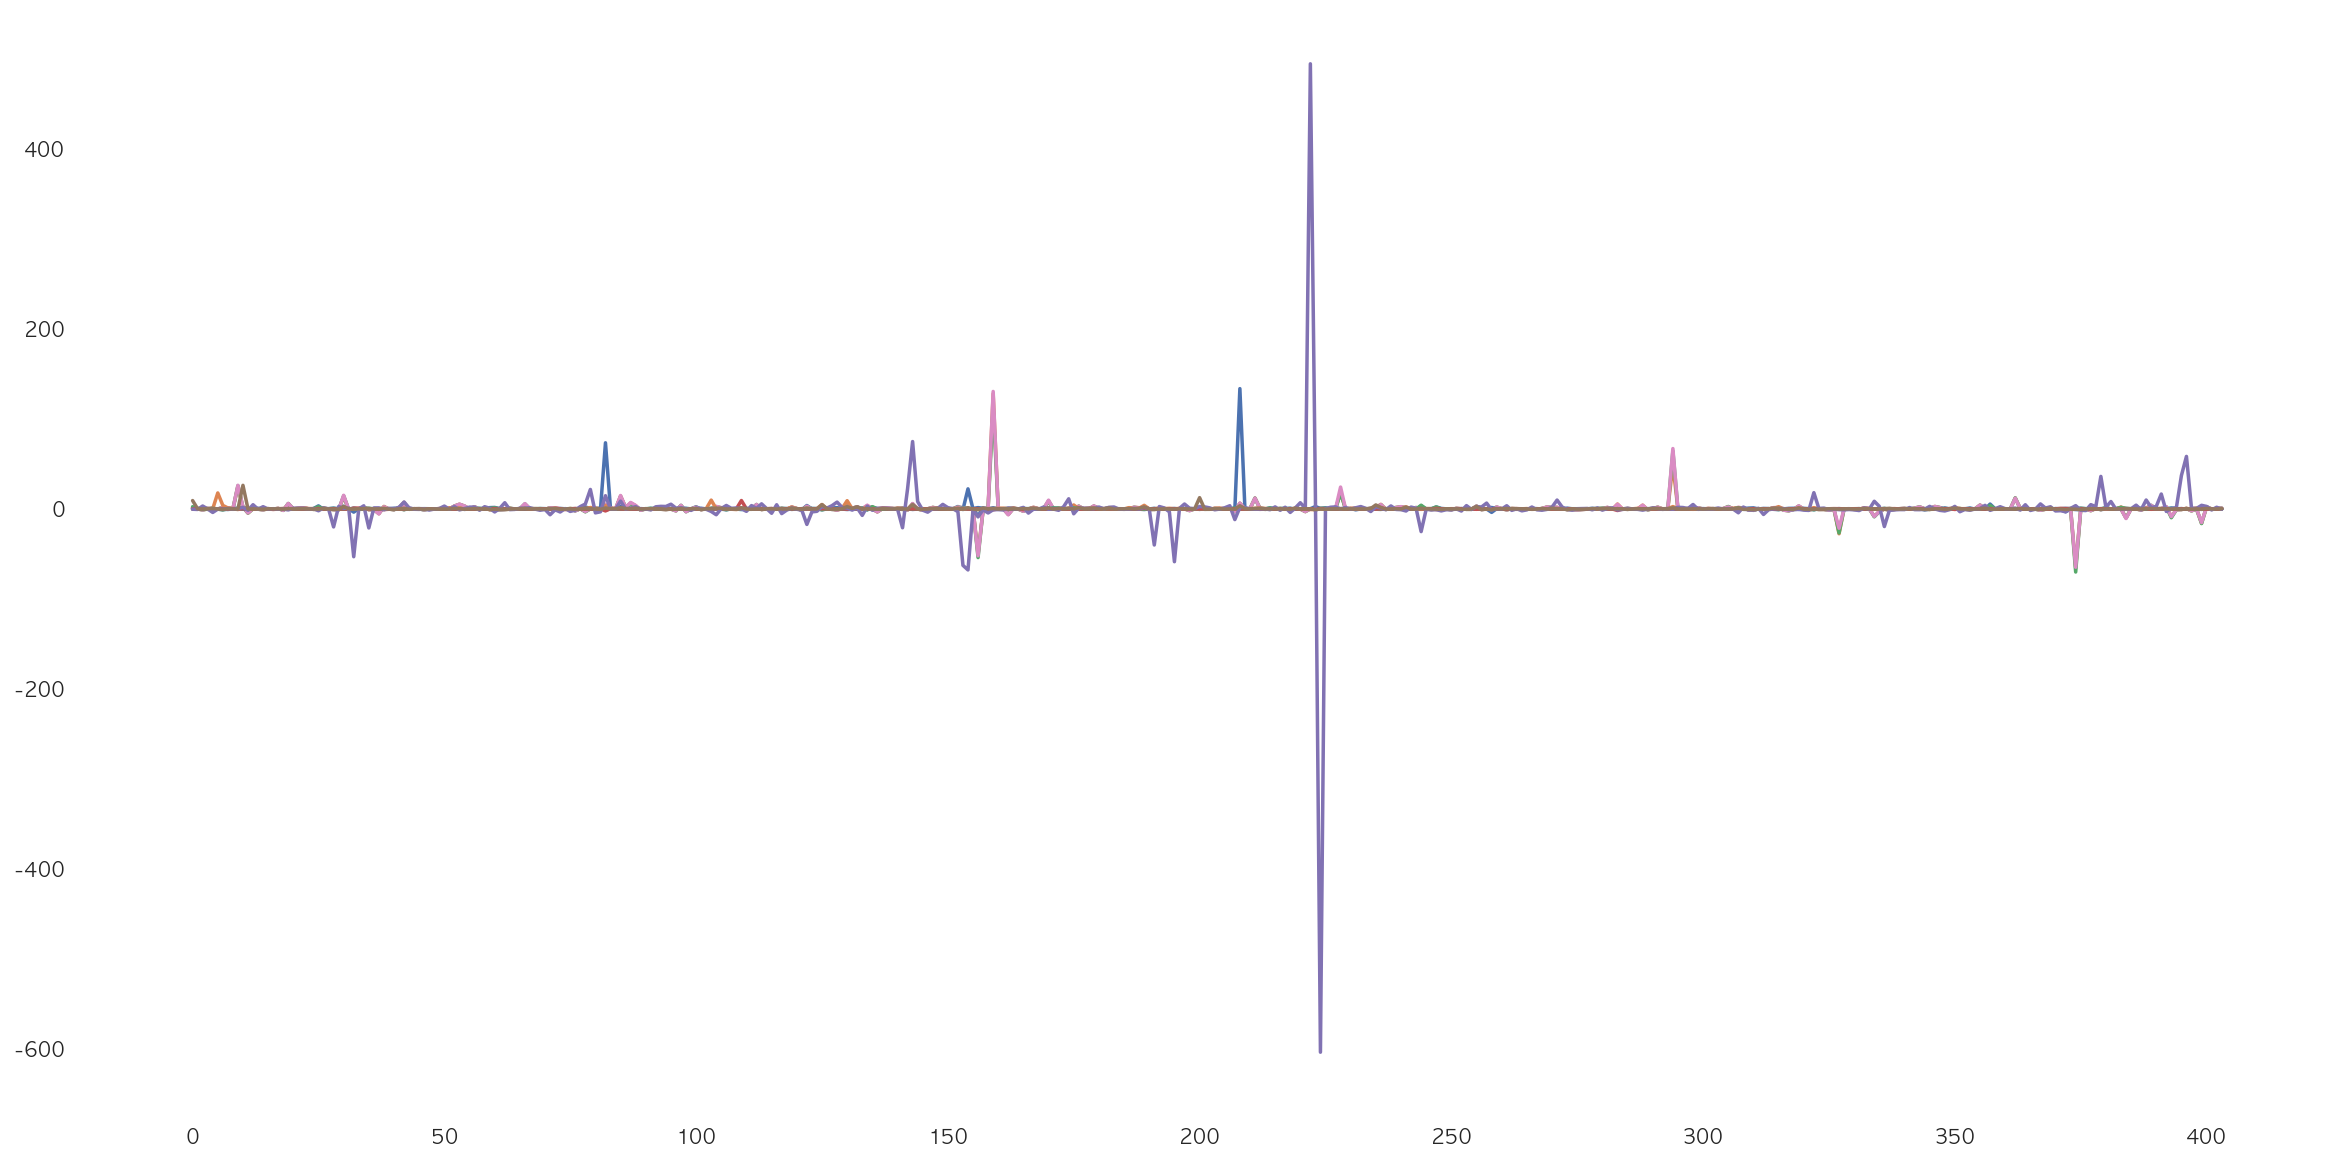

In [35]:
plt.figure(figsize=(20,10))
for i in range(4,20):
    plt.plot(df_sum_2015_2020.iloc[:,i])

plt.show()

In [36]:
# sns.countplot(df_sum_2015_2020["Point"],  palette = "RdBu")
# plt.show()

In [37]:
# plt.figure(figsize=(10,10))
# sns.heatmap(data = df_sum_2015_2020.iloc[:,4:].corr(), annot=True, fmt = '.2f', linewidths=.5, cmap='Blues')
# plt.show()

In [38]:
# plt.figure(figsize=(5,5))
# sns.pairplot(df_sum_2015_2020.iloc[:,4:-3], )
# plt.show()

In [39]:
X = df_sum_2015_2020.iloc[:,4:]
Y = df_sum_2015_2020.iloc[:,2]



vif = pd.DataFrame()
vif["VIF Factor"] = [variance_inflation_factor(
    X.values, i) for i in range(X.shape[1])]
vif["features"] = X.columns
vif = vif.sort_values("VIF Factor").reset_index(drop=True)
vif

,VIF Factor,features
0,1.040223,FCF
1,1.117716,INTCOV
2,1.168689,E
3,1.237445,EQTA
4,1.282333,EBITDATIE
5,1.440884,S
6,1.444321,EBITTS
7,1.550187,G
8,1.803680,Sale
9,1.997839,CURR


In [40]:
robust_scaler = RobustScaler()
rb = robust_scaler.fit(X)
output = robust_scaler.transform(X)
output = pd.DataFrame(output, columns=X.columns, index=list(X.index.values))
output["Y"] = Y
output.describe()

,INTCOV,ROA,ROE,EQTA,CURR,EBITDA,NI,TASSET,Sale,DR,BTEBITDA,EBITDATIE,TB,LTDTA,FCF,EBITTS,ESG등급,G,S,E,Y
count,404.000000,404.000000,404.000000,404.000000,404.000000,404.000000,4.040000e+02,4.040000e+02,4.040000e+02,4.040000e+02,4.040000e+02,4.040000e+02,4.040000e+02,404.000000,404.000000,404.000000,404.000000,404.000000,404.000000,404.000000,404.000000
mean,1.681047,0.507117,0.465053,0.460623,0.023784,0.168611,5.202238e-01,1.950018e-01,5.070410e-02,9.544949e-02,2.299284e-01,4.996570e-01,3.154979e-01,-0.059276,-0.108682,0.556485,0.012211,0.021040,0.272277,-0.086634,45.371287
std,21.407000,8.804583,8.849761,5.769894,1.021632,1.295104,8.574630e+00,1.303980e+00,1.204485e+00,1.305627e+00,1.397386e+00,2.775380e+00,2.098351e+00,1.303445,16.198514,3.916945,0.156689,0.456742,3.734372,2.622657,5.139326
min,-21.484464,-67.364208,-73.374680,-6.073628,-3.075713,-2.980353,-6.211620e+01,-7.678545e+00,-3.929701e+00,-4.878892e+00,-2.455305e+00,-2.025567e+00,-4.588130e+00,-11.771757,-244.617524,-2.172246,-0.400000,-1.500000,-15.000000,-10.000000,30.000000
25%,-0.444254,-0.402109,-0.387432,-0.466028,-0.500194,-0.485628,-4.244004e-01,-4.372751e-01,-4.907797e-01,-5.153752e-01,-4.409305e-01,-4.036191e-01,-4.134731e-01,-0.452666,-0.431777,-0.436878,0.000000,-0.500000,0.000000,0.000000,40.000000
50%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,5.421011e-20,-1.908196e-17,1.897354e-17,1.019150e-17,-2.168404e-18,7.589415e-18,4.336809e-19,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,50.000000
75%,0.555746,0.597891,0.612568,0.533972,0.499806,0.514372,5.755996e-01,5.627249e-01,5.092203e-01,4.846248e-01,5.590695e-01,5.963809e-01,5.865269e-01,0.547334,0.568223,0.563122,0.000000,0.500000,0.000000,0.000000,50.000000
max,371.893811,132.138045,119.524620,109.168136,3.839661,12.871895,1.249706e+02,6.990966e+00,7.633730e+00,8.871543e+00,1.325976e+01,3.861385e+01,1.852354e+01,3.533932,200.323821,62.789680,0.666667,1.500000,15.000000,10.000000,50.000000


In [41]:
output[(output.values >100)]= np.nan
output[(output.values <-100)]= np.nan
output = output.dropna()

In [42]:
df_x = output.iloc[:,:-1]
df_y = output.iloc[:,-1]

X_train, X_test, y_train, y_test = train_test_split(df_x, df_y,test_size=0.3, random_state=5)

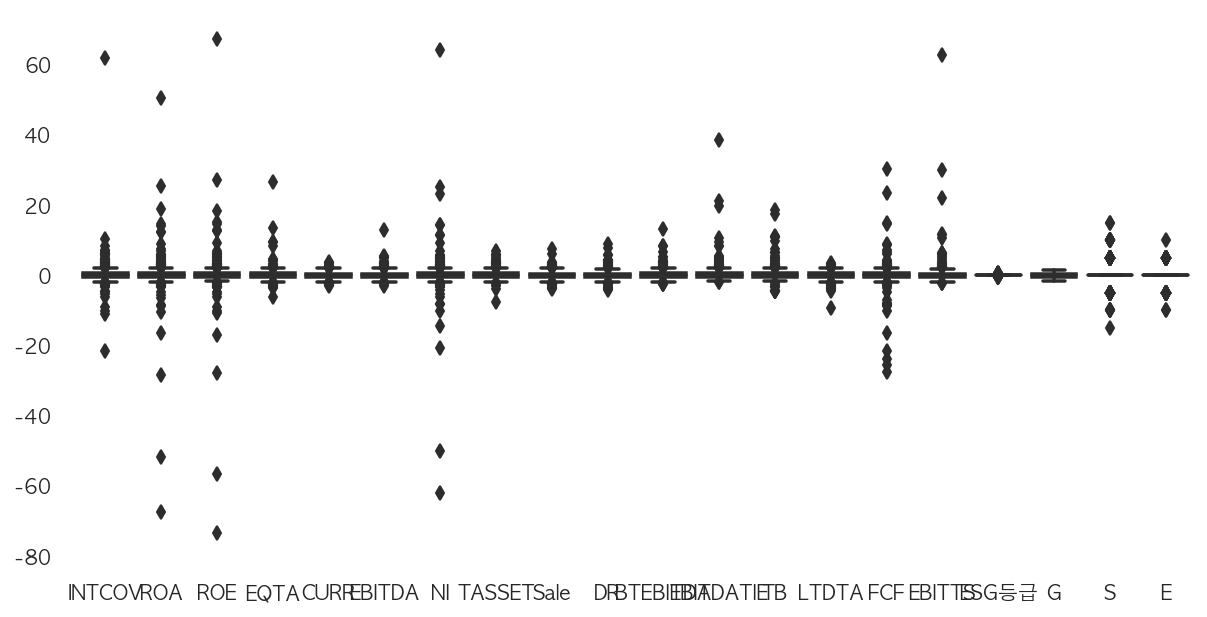

In [43]:
plt.figure(figsize=(10,5))
sns.boxplot(data=df_x, palette = "RdBu")
plt.show()

## OLS Regression

In [44]:
list(output.columns)

['INTCOV',
 'ROA',
 'ROE',
 'EQTA',
 'CURR',
 'EBITDA',
 'NI',
 'TASSET',
 'Sale',
 'DR',
 'BTEBITDA',
 'EBITDATIE',
 'TB',
 'LTDTA',
 'FCF',
 'EBITTS',
 'ESG등급',
 'G',
 'S',
 'E',
 'Y']

In [51]:
model = sm.OLS.from_formula("Y ~LTDTA+CURR+ROE+INTCOV+ROA+EBITDA+TASSET+Sale+EBITDA+DR+EBITDATIE+TB+FCF+EBITTS+E+S+G",data=output)
result = model.fit()
print(result.summary())

                            OLS Regression Results                            
Dep. Variable:                      Y   R-squared:                       0.040
Model:                            OLS   Adj. R-squared:                  0.000
Method:                 Least Squares   F-statistic:                     1.000
Date:                Thu, 02 Jul 2020   Prob (F-statistic):              0.456
Time:                        02:52:01   Log-Likelihood:                -1207.4
No. Observations:                 398   AIC:                             2449.
Df Residuals:                     381   BIC:                             2517.
Df Model:                          16                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     45.4205      0.271    167.908      0.0

## Logistic Regression

In [46]:
# model = sm.Logit.from_formula("C(Y) ~ROA+ROE+INTCOV+EQTA+CURR+EBITDA+TASSET+NI+Sale+DR+BTEBITDA+EBITDATIE+TB+LTDTA+FCF+EBITTS+G+S+E", data=output)
# result1 = model.fit()
# print(result1.summary())

In [47]:
log_clf = LogisticRegression()
log_clf.fit(X_train,y_train) 
cross_val_score(log_clf, X_test, y_test, scoring='accuracy', cv=10).mean()

0.5583333333333333

## DecisionTree

###  ESG

In [48]:
model = DecisionTreeClassifier(min_samples_split=3,random_state=5)
model.fit(X_train, y_train)
cross_val_score(model, X_test, y_test, scoring='accuracy', cv=10).mean()

0.5416666666666667

In [49]:
y_pred = list(model.predict(X_test))
y_true = list(np.array(y_test))
print(len(y_test[y_test==1].dropna()))
print(len(y_test[y_test==-1].dropna()))

0
0


In [50]:
confusion_matrix(y_true, y_pred, labels=[1,0,-1])

ValueError: At least one label specified must be in y_true

In [ ]:
print(classification_report(y_test, y_pred))

In [ ]:
importance = model.feature_importances_
idx = X_train.columns
pd.DataFrame(importance, index =X_train.columns, columns=["Feature_importance"]).sort_values(["Feature_importance"], ascending = False)

In [ ]:
plt.barh(idx,importance, height = 0.8,align='center',alpha=0.8)
plt.show()

### ESG 제거

In [ ]:
X_train1 = X_train.iloc[:,:-3]
X_test1 =  X_test.iloc[:,:-3]

In [ ]:
model = DecisionTreeClassifier(min_samples_split=3,random_state=5)
model.fit(X_train1, y_train)

In [ ]:
from sklearn.model_selection import cross_val_score
cross_val_score(model, X_test1, y_test, scoring='accuracy', cv=10).mean()

In [ ]:
y_pred = list(model.predict(X_test1))
y_true = list(np.array(y_test))

In [ ]:
print(len(y_test[y_test==1].dropna()))

In [ ]:
confusion_matrix(y_true, y_pred, labels=[1,0,-1])

In [ ]:
print(classification_report(y_test, y_pred))

In [ ]:
importance = model.feature_importances_
idx = X_train1.columns
pd.DataFrame(importance, index =X_train1.columns, columns=["Feature_importance"]).sort_values(["Feature_importance"], ascending = False)

In [ ]:
plt.barh(idx,importance, height = 0.8,align='center',alpha=0.8)
plt.show()

## Conclusion

한계점 : 